In [28]:
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline


# download 2-photon data (if not already downloaded)
if not os.path.isfile('data/mesoscope_activity.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    response = urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/mesoscope_activity.npy');
    f=open('data/mesoscope_activity.npy','wb')
    f.write(response.read())
    f.close()

    
# load downloaded data
dat = np.load('data/mesoscope_activity.npy')
dat = dat.item()
sp  = dat['spks']
xyloc = dat['xyloc']

In [29]:
# rastermap algorithm
import sys
sys.path.append('/media/carsen/DATA2/Github/rastermap/rastermap/')
from mapping import RMAP

# rastermap works the same as TSNE or UMAP
# (will take ~ 30s for 6000 neurons x 20000 timepts on a laptop)
# class RMAP:
"""rastermap embedding algorithm
    Rastermap first takes the top iPC's of the data, and then embeds them into
    n_X clusters. It returns upsampled cluster identities (n_X*upsamp).
    Clusters are also computed across Y (n_Y) and smoothed, to help with fitting.
    If n_components=2, n_X x n_X components are used.
    
    Parameters
    -----------
    n_components: int, optional (default: 1)
        dimension of the embedding space
    n_X: int, optional (default: 30)
        number of clusters in X
    n_Y: int, optional (default: 100)
        number of clusters in Y: will be used to smooth data before sorting in X
        if set to zero, no smoothing will occur
    iPC: nparray, int, optional (default: 0-199)
        which PCs to use during optimization
    upsamp: int, optional (default: 25)
        embedding is upsampled in last iteration using kriging interpolation
    sig_upsamp: float, optional (default: 1.0)
        stddev of Gaussian in kriging interpolation for upsampled estimation
    sig_Y: float, optional (default: 1.0)
        stddev of Gaussian smoothing in Y before sorting in X
    sig_anneal: 1D float array, optional (default: starts at 6.0, decreases to 1.0)
        stddev of Gaussian smoothing of clusters, changes across iterations
        default is 50 iterations (last 20 at 1.0)
    init : initialization of algorithm (default: 'pca')
        can use 'pca', 'random', or a matrix n_samples x n_components
        
    Attributes
    ----------
    embedding : array-like, shape (n_samples, n_components)
        Stores the embedding vectors.
    u,sv,v : singular value decomposition of data S, potentially with smoothing
    isort1 : sorting along first dimension of matrix
    isort2 : sorting along second dimension of matrix (if n_Y > 0)
    
"""

model = RMAP(n_components=1, n_X=30, n_Y=100, iPC=np.arange(0,200).astype(np.int32), init='random')
model.fit(sp)

iter 0; 0/1-clusts: 0; self-corr: 0.3842; time: 0.04 s
iter 10; 0/1-clusts: 2; self-corr: 0.5260; time: 0.44 s
iter 20; 0/1-clusts: 1; self-corr: 0.5539; time: 0.83 s
iter 30; 0/1-clusts: 0; self-corr: 0.5928; time: 1.27 s
iter 40; 0/1-clusts: 1; self-corr: 0.5973; time: 1.83 s
iter 49; 0/1-clusts: 1; self-corr: 0.5977; time: 2.32 s
iter 0; 0/1-clusts: 0; self-corr: 0.2558; time: 0.03 s
iter 10; 0/1-clusts: 0; self-corr: 0.4345; time: 0.30 s
iter 20; 0/1-clusts: 0; self-corr: 0.4730; time: 0.56 s
iter 30; 0/1-clusts: 0; self-corr: 0.5163; time: 0.82 s
iter 40; 0/1-clusts: 0; self-corr: 0.5195; time: 1.08 s
iter 49; 0/1-clusts: 0; self-corr: 0.5195; time: 1.31 s


In [30]:
### sort neurons and smooth across neurons and zscore in time
Sm = gaussian_filter1d(sp[model.isort1,:].T, np.minimum(10,int(sp.shape[0]*0.005)), axis=1)
Sm = Sm.T
Sm = zscore(Sm, axis=1)

# (optional) smooth in time
Sm = gaussian_filter1d(Sm, 1, axis=1)

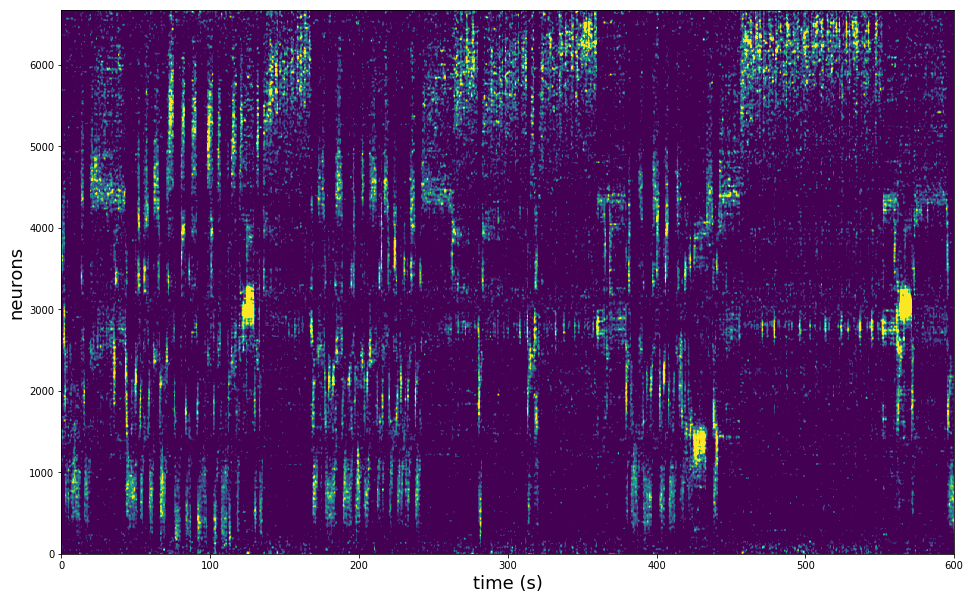

In [31]:
### view neuron sorting
fs = 2.5 # sampling rate of data in Hz
splot = Sm[:,1500:3000]
plt.figure(figsize=(16,10))
ax=plt.imshow(splot, vmin=0,vmax=3,aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('neurons', fontsize=18)
plt.show()

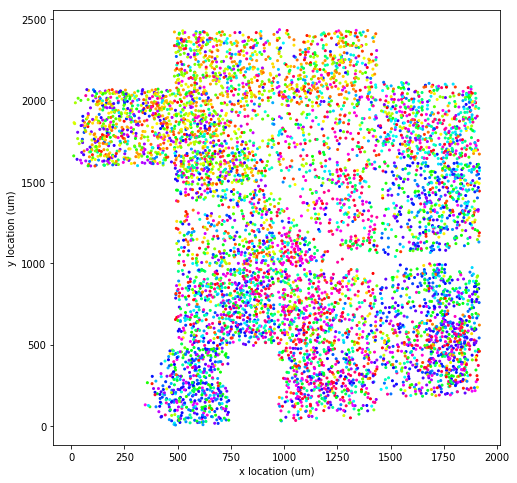

In [32]:
### view positions of cells colored by rastermap

# colormap
cmap = cm.get_cmap('hsv')
cmap = cmap(np.linspace(0.,1,sp.shape[0]))

plt.figure(figsize=(8,8))
# assign color based on embedding
plt.scatter(xyloc[:,0], xyloc[:,1], s=4, color=cmap[model.isort1,:])
plt.xlabel('x location (um)')
plt.ylabel('y location (um)');
plt.show()